<a href="https://www.kaggle.com/code/aisuko/semantic-segmentation?scriptVersionId=164964518" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Semantic segmentation using LoRA see [Semantic segmentation using LoRA](https://www.kaggle.com/code/aisuko/semantic-segmentation-using-lora)

Sementic segmentation assigns a label or class to each individual pixel of an image. There are several types of segmentation, and in the case of semantic segmentation, no distinction is made between unique instances of the same object. Both objects are given the same label(like, "car" instead of "car-1" and "car-2"). Common real_word applications of semantic segmentation include training self-driving cars to identify pedestrians and import traffic information, identifying cells and abnormalities in medical images, and monitoring environmental changes from satellite imagery. Let's finetune a `image segmentation` label model with a same label dataset.

In [1]:
%%capture
!pip install transformers==4.35.2
!pip install datasets==2.15.0
!pip install evaluate==0.4.1
!pip install accelerate==0.25.0

In [2]:
import os
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "Fine-tuning segformer"
os.environ["WANDB_NAME"] = "ft-segformer-with-sceneparse150"

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
!accelerate estimate-memory nvidia/mit-b0 --library_name transformers

Loading pretrained config for `nvidia/mit-b0` from `transformers`...
config.json: 100%|█████████████████████████| 70.0k/70.0k [00:00<00:00, 4.04MB/s]
┌────────────────────────────────────────────────────┐
│      Memory Usage for loading `nvidia/mit-b0`      │
├───────┬─────────────┬──────────┬───────────────────┤
│ dtype │Largest Layer│Total Size│Training using Adam│
├───────┼─────────────┼──────────┼───────────────────┤
│float32│   1.41 MB   │ 12.66 MB │      50.65 MB     │
│float16│   720.5 KB  │ 6.33 MB  │      25.32 MB     │
│  int8 │  360.25 KB  │ 3.17 MB  │      12.66 MB     │
│  int4 │  180.12 KB  │ 1.58 MB  │      6.33 MB      │
└───────┴─────────────┴──────────┴───────────────────┘


# Loading the Dataset

Here are the description for the text fields:
* `image`: a PIL image of the scene
* `annotation`: a PIL image of the segmentation map, which is also the model's target
* `scene_category`: a category id that describes the image scene like "kitchen" of "office". It is also PIL image


In [4]:
from datasets import load_dataset

ds=load_dataset("scene_parse_150", split="train[:500]")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
ds_split=ds.train_test_split(test_size=0.2)
train_ds=ds_split["train"]
test_ds=ds_split["test"]
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>,
 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=L size=500x333>,
 'scene_category': 27}

Let's create a dictionary that maps a label id to a label class which will be useful when we set up the model later.

In [6]:
import json
from huggingface_hub import hf_hub_download

repo_id="huggingface/label-files"
filename="ade20k-id2label.json"

id2label=json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"),"r"))
id2label={int(k): v for k,v in id2label.items()}
label2id={v:k for k,v in id2label.items()}
num_labels=len(id2label)

ade20k-id2label.json:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

# Preprocess

Here we will need to load SegFormer image processor to prepare the images and annotations for the model. Some datasets, like this one, use the zero-index as the background class. However, the background class isn't actually included in the 150 classes, so we will need to set `reduce_labels=True` to subtract one form all the labels. The zero-index is replaced by 255 so it's ignored by SegFormer's loss function.

In [7]:
from transformers import AutoImageProcessor


model_checkpoint="nvidia/mit-b0" # SegFormer (b0-sized) encoder pre-trained-only
image_processor=AutoImageProcessor.from_pretrained(model_checkpoint, reduce_labels=True)

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


It is common to apply some data agumentations to an image dataset to make a model more robust against overfitting. So, here we are going to use the `ColorJitter` function from `torchvision` to randomly change the color properties of an image.

In [8]:
from torchvision.transforms import ColorJitter

jitter=ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

Now let's crate two preprocessing functions to prepare the images and annotations for the model. These functions convert images into `pixel_values` and annotations to `labels`. 

- For the training set, `jitter` is applied before providing the images to the image `processor`. 
- For the test set, the image processor crops and normalizes the images, and only crops the labels because no data augmentation is applied during testing

In [9]:
def train_transforms(example_batch):
    images=[jitter(x) for x in example_batch["image"]]
    labels=[x for x in example_batch["annotation"]]
    inputs =image_processor(images, labels)
    return inputs

def val_transforms(example_batch):
    images=[x for x in example_batch["image"]]
    labels=[x for x in example_batch["annotation"]]
    inputs=image_processor(images, labels)
    return inputs

# To apply the `jitter`  over the entire dataset, use the Dataset `set_transform` function. 
# The transform is applied on the fly which is faster and consumes less disk space:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

# Evaluation

Here we are going to use `mean Intersection over Union`(IoU) metric to evaluate the model's performance. Then create a function to compute the metrics. Our predictions need to be converted to logits first, and then reshaped to match the size of the labels before we can call compute:

In [10]:
import numpy as np
import evaluate
import torch
from torch import nn

metric=evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    # we diable gradient calculation, do not need to back propergation
    # reduces memory consumption for computations
    
    with torch.no_grad(): 
        logits, labels=eval_pred
        logits_tensor=torch.from_numpy(logits)
        # Using bilinear interpolation
        logits_tensor=nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1) # Computes the index of the maximum value along with the specified dimension
        
        pred_labels=logits_tensor.detach().cpu().numpy()
        
        metrics=metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key]=value.tolist()
        return metrics

# Training

In [11]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

def print_trainable_parameters(model):
    trainable_params=0
    all_params=0
    for _, param in model.named_parameters():
        all_params+=param.numel()
        if param.requires_grad:
            trainable_params+=param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_params} || trainable%: {100*trainable_params/all_params:.2f}")


model=AutoModelForSemanticSegmentation.from_pretrained(model_checkpoint, id2label=id2label, label2id=label2id)

print_trainable_parameters(model)

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3752694 || all params: 3752694 || trainable%: 100.00


In [12]:
training_args=TrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    learning_rate=6e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=40,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    report_to="wandb",
    run_name=os.getenv("WANDB_NAME"),
    push_to_hub=False,
)

trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: Currently logged in as: urakiny (causal_language_trainer). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240301_065608-jp0jicdy
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-segformer-with-sceneparse150
wandb: ⭐️ View project at https://wandb.ai/causal_language_trainer/Fine-tuning%20segformer
wandb: 🚀 View run at https://wandb.ai/causal_language_trainer/Fine-tuning%20segformer/runs/jp0jicdy
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=39, training_loss=4.6269833124600925, metrics={'train_runtime': 151.3223, 'train_samples_per_second': 7.93, 'train_steps_per_second': 0.258, 'total_flos': 2.12489182642176e+16, 'train_loss': 4.6269833124600925, 'epoch': 3.0})

In [13]:
import math

eval_results=trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Perplexity: 80.51


In [14]:
kwargs={
    'model_name': os.getenv('WANDB_NAME'),
    'finetuned_from': os.getenv('MODEL_NAME'),
    'tasks': 'Image Segmentation',
#     'dataset_tags':'',
    'dataset':'scene_parse_150'
}

image_processor.push_to_hub(os.getenv("WANDB_NAME"))
trainer.push_to_hub(os.getenv("WANDB_NAME"))

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

'https://huggingface.co/aisuko/ft-segformer-with-sceneparse150/tree/main/'

# Inference

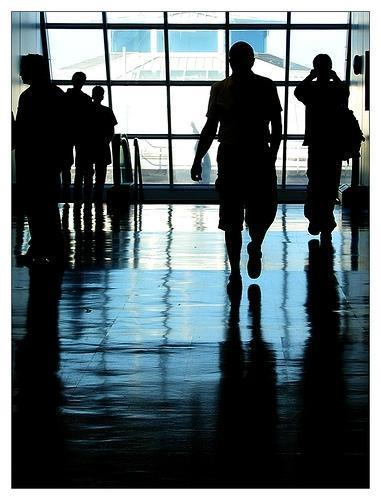

In [15]:
image=ds[0]["image"]
image

In [16]:
from transformers import pipeline

segmenter=pipeline("image-segmentation",model=os.getenv("WANDB_NAME"), device='cuda')
segmenter(image)

[{'score': None,
  'label': 'wall',
  'mask': <PIL.Image.Image image mode=L size=381x500>},
 {'score': None,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=381x500>},
 {'score': None,
  'label': 'floor',
  'mask': <PIL.Image.Image image mode=L size=381x500>},
 {'score': None,
  'label': 'tree',
  'mask': <PIL.Image.Image image mode=L size=381x500>},
 {'score': None,
  'label': 'ceiling',
  'mask': <PIL.Image.Image image mode=L size=381x500>},
 {'score': None,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=381x500>},
 {'score': None,
  'label': 'bed ',
  'mask': <PIL.Image.Image image mode=L size=381x500>},
 {'score': None,
  'label': 'windowpane',
  'mask': <PIL.Image.Image image mode=L size=381x500>},
 {'score': None,
  'label': 'grass',
  'mask': <PIL.Image.Image image mode=L size=381x500>},
 {'score': None,
  'label': 'cabinet',
  'mask': <PIL.Image.Image image mode=L size=381x500>},
 {'score': None,
  'label': 'sidewalk',
  'mask': <PIL.Image.I

# With Model

In [17]:
encoding=image_processor(image, return_tensors="pt")
pixel_values=encoding.pixel_values.to("cuda")

In [18]:
outputs =model(pixel_values=pixel_values)
logits=outputs.logits.cpu()

In [19]:
unsampled_logits=nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg=unsampled_logits.argmax(dim=1)[0]

To visualize the results, create the color map function that maps each class to their RGB values. Then we can combine and plot the image and predicted segmentation map:

In [20]:
# The original code is here: https://github.com/tensorflow/models/blob/3f1ca33afe3c1631b733ea7e40c294273b9e406d/research/deeplab/utils/get_dataset_colormap.py#L51
# License: Apache License 2.0
# Adapte by Aisuko
# Adapte: Sun 10 Dec 2023
def create_ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

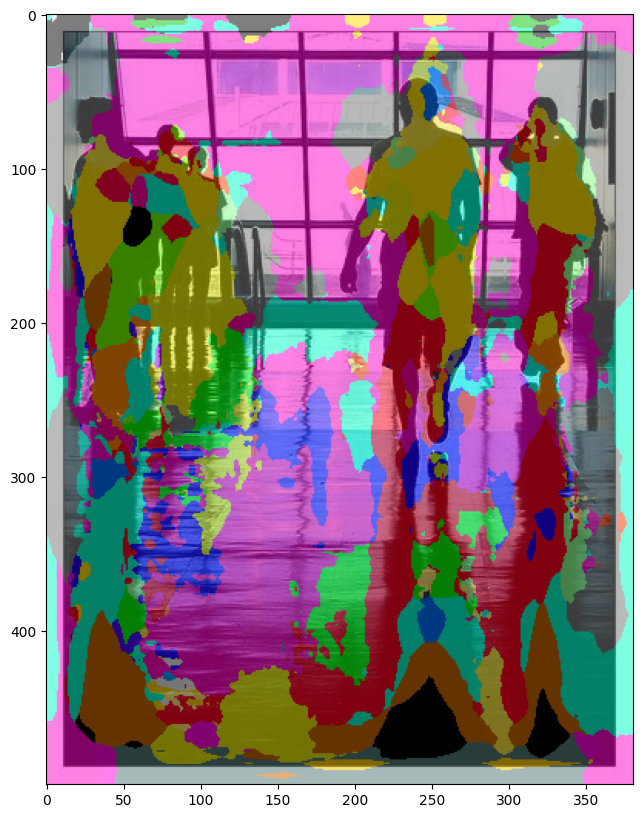

In [21]:
import matplotlib.pyplot as plt
import numpy as np

color_seg=np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette=np.array(create_ade20k_label_colormap())
for label, color in enumerate(palette):
    color_seg[pred_seg==label, :]=color
color_seg=color_seg[...,::-1] # convert to BGR

img=np.array(image)*0.5 +color_seg*0.5 # plot the image with the sementation map
img=img.astype(np.uint8)

plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()